### Differential Equation

$\frac{\mathrm{d}\Psi_1}{\mathrm{d}x} = cos(x) + \Psi_1^2 + \Psi_2 - (1 + x^2 + sin^2(x)),$

$\frac{\mathrm{d}\Psi_2}{\mathrm{d}x} = 2x - (1 - x^2)sin(x) + \Psi_1\Psi_2,$

$\Psi_1(0) = 0, \Psi_2(0) = 1, x \in [0, 3]$

In [25]:
from typing import List, Tuple, Callable
import autograd.numpy as np
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
PSI_0 = np.array([0, 1])

def derivative(x, psi) -> np.ndarray:
    """Example #4 derivative.
    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_1_dot = np.cos(x) + psi[0]**2 + psi[1] - (1 + x**2 + np.sin(x)**2)
    psi_2_dot = 2 * x - (1 - x**2) * np.sin(x) + psi[0] * psi[1] 
    return np.array([psi_1_dot, psi_2_dot])

def analytical_solution(x):
    """Analytical solution to example #4.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
    psi_1 = np.sin(x)
    psi_2 = 1 + x**2

    return np.array([psi_1, psi_2])

### Activation Functions

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

### Neural Network

![](NN.png "Neural Network")

In [124]:
class NeuralNetwork:
    """A neural network class for solving ODEs. Can be combine with other neural networks to solve system of ODEs.
        Attributes:
            init_condition (float): Initial condition for the target function.
            derivative (Callable): Function that calculates the target derivative of the neural network.
            input_size (int): Size of the input layer.
            hidden_sizes (np.array): Array of integers representing the sizes of the hidden layers.
            output_size (int): Size of the output layer.
            activation_fns (List[Callable]): List of activation functions for each layer.
            weights (List[np.array]): List of weights and biases for each layer.

        Methods:
            init_weights(): Initializes the weights and biases of the neural network.
            forward(t: np.array, weights: List[np.array]) -> np.array: Makes a forward pass through the neural network.
            trial_solution(t: np.array, weights: List[np.array]) -> np.ndarray: Calculates the trial solution.
            elementwise_trial_solution(t: np.array, weights: List[np.array]) -> np.ndarray: Calculates the trial solution elementwise.
            trial_grad(t: np.array, weights: List[np.array]) -> np.array: Calculates the gradient of the trial solution with respect to t.
    """
    def __init__(self, init_condition: np.array, derivative: Callable, input_size: int, hidden_sizes: np.array, output_size: int, activation_fns: List[Callable]):
        self.init_condition = init_condition
        self.derivative = derivative
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_fns = activation_fns
        self.weights = [None] * (hidden_sizes.shape[0] + 1) # +1 for the output
        self.init_weights()

    def init_weights(self):
        """ Initializes the weights and biases of the neural network 
        Args:
            None
        
        Returns:
            None
        """
        # hidden weights and biases
        self.weights[0] = np.random.randn(self.hidden_sizes[0], self.input_size + 1) # +1 for the bias
        for i in range(1, self.hidden_sizes.shape[0]):
            self.weights[i] = np.random.randn(self.hidden_sizes[i], self.hidden_sizes[i - 1] + 1) # +1 for the bias

        # output weights and biases
        self.weights[-1] = np.random.randn(self.output_size, self.hidden_sizes[-1] + 1) # +1 for the bias

    def forward(self, t: np.array, weights: List[np.array]) -> np.array:
        """Makes a forward pass through the neural network.

        Args:
            t: The t vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the output of the neural network of dim(self.output_size, len(t)).
        """
        num_layers = len(weights)
        # row matrix
        t = t.reshape(-1, t.size)

        z = None
        a = t
        for i in range(num_layers):
            z = np.matmul(weights[i], np.concatenate((np.ones((1, t.size)), a), axis = 0))
            a = self.activation_fns[i](z)
        return z

    def trial_solution(self, t: np.array, weights: List[np.array]) -> np.ndarray:
        """Calculates the trial solution of the system of ODEs.
        
        Args:
            t: The input vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the trial solution of the system of ODEs
            dimension (len(t),)
        """
        fp = self.forward(t, weights).reshape(t.size)
        return self.init_condition + t * fp

    def trial_grad(self, t: np.array, weights: List[np.array]) -> np.array:
        """Calculates the gradient of the trial solution of the Lorentz System.
        
        Args:
            t: The input vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the gradient of the trial solution of the Lorentz System with 
            dimension (len(t),)
        """
        return elementwise_grad(self.trial_solution, 0)(t, weights)

### Loss Function

In [125]:
def mse_loss_function(t: np.array, neural_networks: List[NeuralNetwork], weights_list: List[List[np.array]]) -> List[float]:
    """Calculates the mean squared error a list of neural network.

    Args:
        t: The input vector
        neural_networks: A list of neural networks

    Returns:
        Mean squared error value
    """
    loss = [None] * len(neural_networks)
    trial_sol = np.array([neural_networks[i].trial_solution(t, weights_list[i]) for i in range(len(neural_networks))])
    
    for i in range(len(neural_networks)):
        grad_star = neural_networks[i].derivative(t, trial_sol)
        grad = neural_networks[i].trial_grad(t, weights_list[i])
        error = grad_star - grad
        loss[i] = np.linalg.norm(error, 'fro') / np.sqrt(np.size(error))

    return loss

def elementwise_loss_function(t: np.array, neural_networks: List[NeuralNetwork], weights_list, index) -> float:
    return mse_loss_function(t, neural_networks, weights_list)[index]


### Optimizers

In [193]:
def gradient_descent(t: np.array, neural_networks: List[NeuralNetwork], num_iter: int, learn_rate: float):
    """Runs gradient descent for a given number of iterations

    Args:
        t: The input vector
        num_iter: The number of iterations
        learn_rate: The learning rate
    
    Returns:
        neural_networks: A list of neural networks after gradient descent
    """
    loss_grad_function = grad(elementwise_loss_function, 2)

    for i in range(num_iter):
        weights_list = [neural_networks[j].weights for j in range(len(neural_networks))]
        print_loss(t, neural_networks, weights_list, i)

        for j in range(len(neural_networks)):
            loss_grad = loss_grad_function(t, neural_networks, weights_list, j)
            
            for k in range(len(neural_networks[j].weights)):
                neural_networks[j].weights[k] = neural_networks[j].weights[k] - learn_rate * loss_grad[j][k]

    return neural_networks

def adam(t, neural_networks, num_iters=10000, step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    loss_grad_function = grad(elementwise_loss_function, 2)

    m = [[np.zeros_like(neural_networks[i].weights[j]) for j in range(len(neural_networks[0].weights))] for i in range(len(neural_networks))]
    v = [[np.zeros_like(neural_networks[i].weights[j]) for j in range(len(neural_networks[0].weights))] for i in range(len(neural_networks))]

    mhat = [[None] * len(neural_networks[i].weights) for i in range(len(neural_networks))]
    vhat = [[None] * len(neural_networks[i].weights) for i in range(len(neural_networks))]

    prev_loss = 0
    for i in range(num_iters):
        weights_list = [neural_networks[j].weights for j in range(len(neural_networks))]
        prev_loss = print_loss(t, neural_networks, weights_list, i, prev_loss)

        for j in range(len(neural_networks)):
            g = loss_grad_function(t, neural_networks, weights_list, j)
            
            for k in range(len(neural_networks[j].weights)):
                m[j][k] = (1 - b1) * g[j][k]      + b1 * m[j][k]  # First  moment estimate.
                v[j][k] = (1 - b2) * (g[j][k]**2) + b2 * v[j][k]  # Second moment estimate.
                mhat[j][k] = m[j][k] / (1 - b1**(i + 1))    # Bias correction.
                vhat[j][k] = v[j][k] / (1 - b2**(i + 1)) 
                neural_networks[j].weights[k] = neural_networks[j].weights[k] - step_size * mhat[j][k]/(np.sqrt(vhat[j][k]) + eps)
    
    return neural_networks

def print_loss(t: np.array, neural_networks: List[NeuralNetwork], weights_list: List[List[np.array]], iter: int, prev_loss):
    """Prints the iteration number and loss of the neural networks.

    Args:
        t: The input vector
        neural_networks: A list of neural networks
        weights_list: The weights and biases of the neural networks
    
    Returns:
        loss: The loss of the neural networks
    """
    loss = mse_loss_function(t, neural_networks, weights_list)

    print("\033[38;5;189m" + "Iteration: ", iter)
    print("\033[38;5;210m", loss)

    return loss


### Training

In [194]:
def train(init_conditions):
    t = np.arange(0, 3, 0.3)
    hidden_sizes = np.array([10])
    activation_fns = [sigmoid] * (len(hidden_sizes)) + [lambda x: x]
    nn1 = NeuralNetwork(init_conditions[0], derivative, 1, hidden_sizes, 1, activation_fns)
    nn2 = NeuralNetwork(init_conditions[1], derivative, 1, hidden_sizes, 1, activation_fns)
    adam(t, [nn1, nn2], num_iters=100000, step_size=0.001)

    return [nn1, nn2]

nns = train(PSI_0)

Iteration:  0
 [8.944842388448738, 5.785298501882782]
Iteration:  1
 [8.892904130478707, 5.775468686011619]
Iteration:  2
 [8.842453377951486, 5.767841961964772]
Iteration:  3
 [8.793516559336704, 5.762376560093642]
Iteration:  4
 [8.746116057989939, 5.759020320984328]
Iteration:  5
 [8.700269817909902, 5.7577103997652195]
Iteration:  6
 [8.655990947640657, 5.758373009942]
Iteration:  7
 [8.613287325874913, 5.760923254398579]
Iteration:  8
 [8.572161222098286, 5.765265152161698]
Iteration:  9
 [8.532608965729487, 5.771292052317134]
Iteration:  10
 [8.494620724695878, 5.77888766948555]
Iteration:  11
 [8.458180468235994, 5.787927853879571]
Iteration:  12
 [8.423266153876044, 5.79828285676154]
Iteration:  13
 [8.389850091066092, 5.80981948771325]
Iteration:  14
 [8.357899361991448, 5.82240259687302]
Iteration:  15
 [8.327376196971734, 5.835895789147604]
Iteration:  16
 [8.298238280751812, 5.850161700670323]
Iteration:  17
 [8.270439022732138, 5.865062208012107]
Iteration:  18
 [8.2439278

KeyboardInterrupt: 

### Evaluating Results

In [141]:
def plot_ode(neural_network: NeuralNetwork, scale=1, dt=0.3):
   t = np.arange(0, 3, dt)
   res = neural_network.trial_solution(t, neural_network.weights)
   fig = plt.figure(figsize=(5, 5))
   ax = fig.add_subplot()
   ax.plot(res[0], res[1], lw=1)
   ax.plot(analytical_solution(t)[0], analytical_solution(t)[1], lw=1)
   plt.legend(['nn', 'analytical'])

   print(analytical_solution(t) - res[0])

def plot_system_ode(neural_networks: List[NeuralNetwork], scale=1, dt=0.3):
   t = np.arange(0, 3, dt)
   res = [neural_networks[i].trial_solution(t, neural_networks[i].weights) for i in range(len(neural_networks))]
   fig = plt.figure(figsize=(5, 5))
   ax = fig.add_subplot()
   ax.plot(res[0], res[1], lw=1)
   ax.plot(analytical_solution(t)[0], analytical_solution(t)[1], lw=1)
   plt.legend(['nn', 'analytical'])

def simulate_sode(t, initial_conditions, derivative) -> Tuple[np.ndarray, np.ndarray]:
   """Simulate the system of ODEs over the time interval [0, dt * num_steps].

   Args:
      dt: The t step
      initial_conditions: The initial conditions
      num_steps: The number of t steps to calculate
   
   Returns:
      A tuple of two NumPy arrays: the function output values, and the derivatives.
   """
   df_dt = np.empty((len(t), len(initial_conditions)))
   output = np.empty((len(t), len(initial_conditions)))
   output[0] = initial_conditions

   for i in range(len(t) - 1):
      dt = t[i + 1] - t[i]
      output[i + 1] = output[i] + derivative(t[i], output[i]) * dt
      df_dt[i] = derivative(t[i], output[i])
   
   return output, df_dt

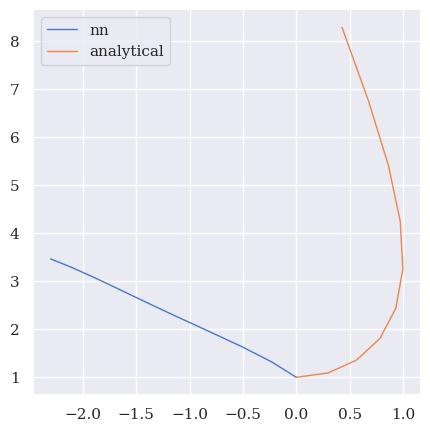

In [142]:
sns.set_theme(style="darkgrid", palette="muted", font='DeJavu Serif')
plot_system_ode(nns)
sns.despine()